# Finance ROIC

In [1]:
import os
import sys
import pickle
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import dotenv

dotenv.load_dotenv()
token = os.getenv('TUSHARE_TOKEN')

In [3]:
import tushare as ts

ts.set_token(token)
pro = ts.pro_api()

In [4]:
# 准备缓存目录
cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

In [5]:
# 获取当前所有A股上市公司列表
cache_file = os.path.join(cache_dir, 'stock_list.pkl')
if os.path.exists(cache_file):
    print('load stock list from cache')
    with open(cache_file, 'rb') as f:
        stock_list = pickle.load(f)
else:
    print('load stock list from tushare')
    stock_list = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')
    with open(cache_file, 'wb') as f:
        pickle.dump(stock_list, f)
print(stock_list)

load stock list from cache
        ts_code  symbol     name area industry list_date
0     000001.SZ  000001     平安银行   深圳       银行  19910403
1     000002.SZ  000002      万科A   深圳     全国地产  19910129
2     000004.SZ  000004     国华网安   深圳     软件服务  19910114
3     000005.SZ  000005     ST星源   深圳     环境保护  19901210
4     000006.SZ  000006     深振业A   深圳     区域地产  19920427
...         ...     ...      ...  ...      ...       ...
5336  873703.BJ  873703     广厦环能   北京     专用机械  20231205
5337  873726.BJ  873726     卓兆点胶   江苏     机械基件  20231019
5338  873806.BJ  873806     N云星宇   北京     软件服务  20240111
5339  873833.BJ  873833     美心翼申   重庆     汽车配件  20231108
5340  689009.SH  689009  九号公司-WD   北京      摩托车  20201029

[5341 rows x 6 columns]


In [6]:
# 获取2010年以来的所有利润表数据
cache_file = os.path.join(cache_dir, 'income.pkl')
if os.path.exists(cache_file):
    print('load income from cache')
    with open(cache_file, 'rb') as f:
        all_income = pickle.load(f)
else:
    print('load income from tushare')
    all_income = pd.DataFrame()
    print('process: ', end='')
    for year in range(2010, 2024):
        print(year, end='...')
        period = f"{year}1231"
        income = pro.income_vip(period=period)
        income = income.dropna(axis=1, how='all')
        if not income.empty:
            all_income = pd.concat([all_income, income])
    with open(cache_file, 'wb') as f:
        pickle.dump(all_income, f)
    print('done')
    all_income.reset_index(drop=True, inplace=True)
print(all_income)

load income from cache
        ts_code  ann_date f_ann_date  end_date report_type comp_type end_type  \
0     000563.SZ  20110118   20110118  20101231           1         2        4   
1     601678.SH  20110124   20110124  20101231           1         1        4   
2     002349.SZ  20110119   20110119  20101231           1         1        4   
3     002299.SZ  20110125   20110125  20101231           1         1        4   
4     600420.SH  20110128   20110128  20101231           1         1        4   
...         ...       ...        ...       ...         ...       ...      ...   
8662  301526.SZ  20231207   20231207  20221231           1         1        4   
8663  600806.SH  20230301   20230901  20221231           1         1        4   
8664  002564.SZ  20230629   20231109  20221231           1         1        4   
8665  873833.BJ  20231027   20231027  20221231           1         1        4   
8666  836193.BJ  20230330   20230628  20221231           1         1        4   

    

In [7]:
# 获取2010年以来的所有资产负债表数据
cache_file = os.path.join(cache_dir, 'balancesheet.pkl')
if os.path.exists(cache_file):
    print('load balancesheet from cache')
    with open(cache_file, 'rb') as f:
        all_balancesheet = pickle.load(f)
else:
    print('load balancesheet from tushare')
    all_balancesheet = pd.DataFrame()
    print('process: ', end='')
    for year in range(2010, 2024):
        print(year, end='...')
        period = f"{year}1231"
        balancesheet = pro.balancesheet_vip(period=period)
        balancesheet = balancesheet.dropna(axis=1, how='all')
        if not balancesheet.empty:
            all_balancesheet = pd.concat([all_balancesheet, balancesheet])
    with open(cache_file, 'wb') as f:
        pickle.dump(all_balancesheet, f)
    print('done')
    all_balancesheet.reset_index(drop=True, inplace=True)
print(all_balancesheet)

load balancesheet from cache
        ts_code  ann_date f_ann_date  end_date report_type comp_type end_type  \
0     601658.SH  20150901   20150901  20101231           1         2        4   
1     601068.SH  20150113   20150113  20101231           1         1        4   
2     603299.SH  20151216   20151216  20101231           1         1        4   
3     603223.SH  20150610   20150610  20101231           1         1        4   
4     605589.SH  20140127   20140127  20101231           1         1        4   
...         ...       ...        ...       ...         ...       ...      ...   
6120  301566.SZ  20231212   20231212  20221231           1         1        4   
6121  873879.BJ  20230421   20231213  20221231           1         1        4   
6122  873731.BJ  20230401   20231123  20221231           1         1        4   
6123  839418.BJ  20230427   20231104  20221231           1         1        4   
6124  873393.BJ  20230421   20231102  20221231           1         1        4   

In [8]:
# 合并利润表和资产负债表
df = pd.merge(all_balancesheet, all_income, on=[
    'ts_code', 'update_flag', 'ann_date', 'f_ann_date',
    'end_date', 'report_type', 'comp_type', 'end_type'])

# 关联股票代码信息
df = pd.merge(df, stock_list[['ts_code', 'name']], on='ts_code')

In [9]:
# 投资资产收益率 = 净利润(不含少数股东损益) / 股东权益合计(不含少数股东权益)
df['ROIC'] = df['n_income_attr_p'] / df['total_hldr_eqy_exc_min_int']

In [10]:
df['year'] = df['end_date'].str[:4]
df['year'] = pd.to_numeric(df['year'])
df = df.sort_values(by=['year', 'ts_code'])

<Axes: title={'center': 'ROIC by year'}, xlabel='year'>

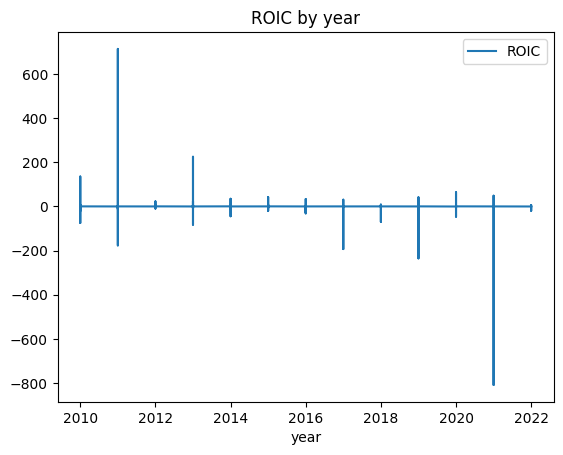

In [11]:
df.plot(x='year', y='ROIC', kind='line', title='ROIC by year')

<Axes: title={'center': 'ROIC by year (filtered by 1% and 99% quantiles)'}, xlabel='year'>

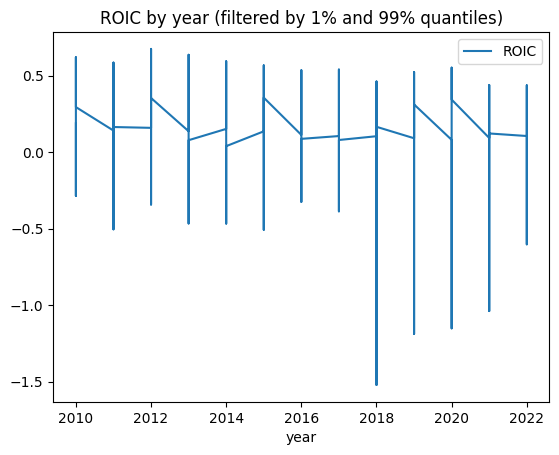

In [12]:
grouped_df = df.groupby('year')

# Calculate the 1% and 99% quantiles of the 'ROIC' column for each group
q1 = grouped_df['ROIC'].quantile(0.01)
q99 = grouped_df['ROIC'].quantile(0.99)

filtered_df = grouped_df.apply(lambda x: x[(x['ROIC'] >= q1[x.name]) & (x['ROIC'] <= q99[x.name])])

filtered_df.plot(x='year', y='ROIC', kind='line', title='ROIC by year (filtered by 1% and 99% quantiles)')

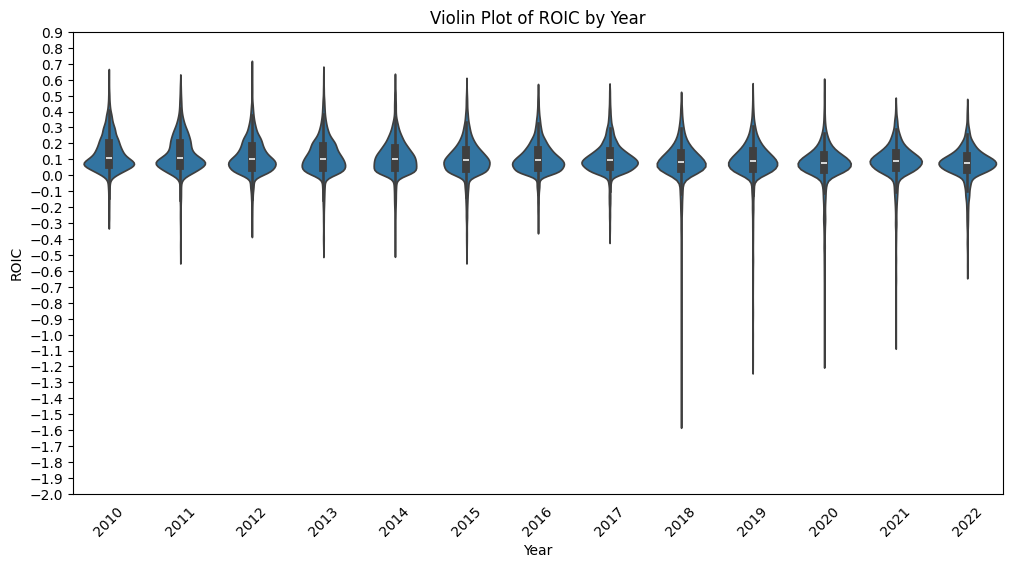

In [13]:
plt.figure(figsize=(12, 6))

# Create a violin plot
sns.violinplot(data=filtered_df, x='year', y='ROIC')

# Scratch the plot with two times
plt.xticks(rotation=45)
plt.tick_params(axis='x', which='both', bottom=False, top=False)

# Add more ticks on the y-axis
plt.yticks(np.arange(-2, 1, 0.1))

# Set labels and title
plt.xlabel('Year')
plt.ylabel('ROIC')
plt.title('Violin Plot of ROIC by Year')

# Show the plot
plt.show()


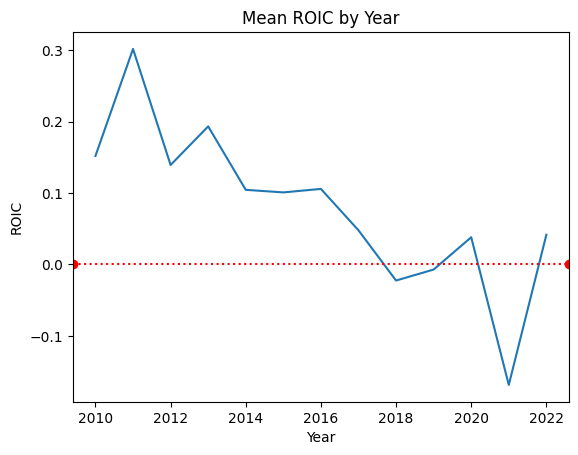

In [14]:
# Group by year and calculate mean ROIC
mean_roic = df.groupby('year')['ROIC'].mean()

# Plot ROIC vs. year
mean_roic.plot(x='year', y='ROIC', kind='line')

# Add horizontal line at y=0
plt.axhline(0, color='red', linestyle=':', marker='o')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('ROIC')
plt.title('Mean ROIC by Year')

# Show the plot
plt.show()
